# Data Loading and Imports

In [13]:
from PIL import Image as PilImage
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from IPython.display import Image, display
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras.optimizers import Adam
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [2]:
image_dir = 'C:\\Users\\howar\\Desktop\\Capstone\\FloridaSnakePredictor\\Snake Photos'

In [3]:
all_images = set(f for f in os.listdir(image_dir) if f.endswith('.jpg'))

In [4]:
venomous_snakes = ["Florida Cottonmouth.jpg", "Florida Cottonmouth 1.jpg", "Dusky Pygmy Rattlesnake.jpg", "Dusky Pygmy Rattlesnake 1.jpg", "Eastern Diamond-backed Rattlesnake.jpg", "Eastern Diamond-backed Rattlesnake 1.jpg",  "Harlequin Coralsnake.jpg", "Harlequin Coralsnake 1.jpg", "Eastern Copperhead.jpg", "Eastern Copperhead 1.jpg", "Timber Rattlesnake.jpg", "Timber Rattlesnake 1.jpg"]

venomous_snakes = set(venomous_snakes)

non_venomous_snakes = all_images - venomous_snakes

In [5]:
venomous_snakes = list(venomous_snakes)
non_venomous_snakes = list(non_venomous_snakes)



df = pd.DataFrame({
    'Venomous': pd.Series(venomous_snakes),
    'Non-venomous': pd.Series(non_venomous_snakes)
})

df

,Venomous,Non-venomous
0,Timber Rattlesnake.jpg,Red Cornsnake 1.jpg
1,Florida Cottonmouth 1.jpg,Gray Ratsnake 1.jpg
2,Eastern Copperhead 1.jpg,Florida Brownsnake 1.jpg
3,Eastern Diamond-backed Rattlesnake.jpg,Eastern Indigo Snake.jpg
4,Florida Cottonmouth.jpg,Diamond-backed Watersnake.jpg
...,...,...
91,NaN,North American Racer 1.jpg
92,NaN,Red Cornsnake.jpg
93,NaN,Rough Greensnake 1.jpg
94,NaN,Rim Rock Crowned Snake.jpg


In [6]:
venomous_snakes

['Timber Rattlesnake.jpg',
 'Florida Cottonmouth 1.jpg',
 'Eastern Copperhead 1.jpg',
 'Eastern Diamond-backed Rattlesnake.jpg',
 'Florida Cottonmouth.jpg',
 'Eastern Copperhead.jpg',
 'Harlequin Coralsnake.jpg',
 'Dusky Pygmy Rattlesnake.jpg',
 'Eastern Diamond-backed Rattlesnake 1.jpg',
 'Timber Rattlesnake 1.jpg',
 'Dusky Pygmy Rattlesnake 1.jpg',
 'Harlequin Coralsnake 1.jpg']

# Data Editing and Prep.

In [7]:
# Get a list of all files in that directory
all_files = os.listdir(image_dir)

# Filter the list for files ending in '.jpg'
image_paths = [os.path.join(image_dir, file) for file in all_files if file.endswith('.jpg')]

In [8]:
# Initialize an empty list to store the numpy arrays
images = []

for path in image_paths:
    # Open the image file
    with PilImage.open(path) as img:
        # Convert the image data to a numpy array
        img_array = np.array(img)
        
        # Append the image array to the list
        images.append(img_array)

# Convert the list of image arrays into a single numpy array
images = np.array(images)

print(images.shape)
# Images, Height, Width, Color Channels

(108, 600, 900, 3)


In [9]:
labels = []

for path in image_paths:
    # Get the name of the snake from the path
    snake_name = os.path.basename(path)  # this gets the filename with the extension
    
    # Check if the snake is venomous
    if snake_name in venomous_snakes:
        # If it is, append 1 to the labels list
        labels.append(1)
    else:
        # If it's not, append 0 to the labels list
        labels.append(0)

# Convert the list of labels into a numpy array
labels = np.array(labels)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])

# Models

#### Train Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

### Model 1 (SGD)

In [11]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(weights))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(600, 900, 3)))  # change input shape to match your images
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

# Set the learning rate
learning_rate = 0.01

# Create an SGD optimizer with the specified learning rate
sgd = SGD(lr=learning_rate)

# Compile the model with the SGD optimizer
model.compile(optimizer=sgd, loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=early_stopping)


C:\Users\howar\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/20
2/2 [==============================] - 6s 3s/step - loss: 5.7046 - val_loss: 0.4860
Epoch 2/20
2/2 [==============================] - 6s 3s/step - loss: 0.3824 - val_loss: 0.4212
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 0.4139 - val_loss: 0.5777
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 0.4411 - val_loss: 0.5530
Epoch 5/20
2/2 [==============================] - 5s 3s/step - loss: 0.3796 - val_loss: 0.5079


In [16]:
loss = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Test loss: {loss:.4f}, Test F1 score: {f1*100:.2f}%')

Test loss: 0.5079, Test F1 score: 83.30%


In [17]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


### Model 2 (adam)

In [18]:
weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(weights))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(600, 900, 3)))  # change input shape to match your images
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.01)

model.compile(optimizer='adam', loss='binary_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, callbacks=[early_stopping])

Epoch 1/20
2/2 [==============================] - 6s 3s/step - loss: 115.2893 - val_loss: 74.9394
Epoch 2/20
2/2 [==============================] - 6s 3s/step - loss: 121.3039 - val_loss: 19.0860
Epoch 3/20
2/2 [==============================] - 6s 3s/step - loss: 25.4102 - val_loss: 2.2814
Epoch 4/20
2/2 [==============================] - 6s 3s/step - loss: 13.5676 - val_loss: 0.5779
Epoch 5/20
2/2 [==============================] - 6s 3s/step - loss: 7.1046 - val_loss: 0.4007
Epoch 6/20
2/2 [==============================] - 6s 3s/step - loss: 1.5528 - val_loss: 0.5290
Epoch 7/20
2/2 [==============================] - 6s 3s/step - loss: 0.6498 - val_loss: 0.6286
Epoch 8/20
2/2 [==============================] - 6s 3s/step - loss: 0.3076 - val_loss: 0.6222


In [19]:
loss = model.evaluate(X_test, y_test, verbose=0)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)  

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Test loss: {loss:.4f}, Test F1 score: {f1*100:.2f}%')

Test loss: 0.6222, Test F1 score: 83.30%


In [20]:
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


# Visualizations 

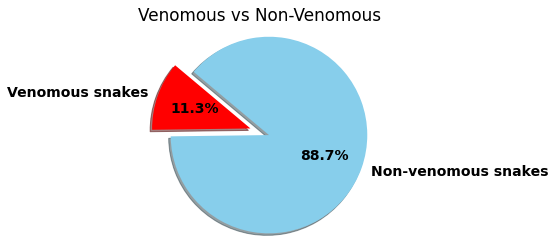

In [25]:
labels = 'Venomous snakes', 'Non-venomous snakes'
sizes = [6, 47]  
colors = ['red', 'skyblue']  
explode = (0.2, 0)  


plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Venomous vs Non-Venomous')
plt.show()

In [22]:
venomous_snake_names = ["Harlequin Coralsnake", "Dusky Pygmy Rattlesnake", "Eastern Diamond-backed Rattlesnake", "Eastern Copperhead", "Florida Cottonmouth", "Timber Rattlesnake"]
print(venomous_snake_names)

['Harlequin Coralsnake', 'Dusky Pygmy Rattlesnake', 'Eastern Diamond-backed Rattlesnake', 'Eastern Copperhead', 'Florida Cottonmouth', 'Timber Rattlesnake']


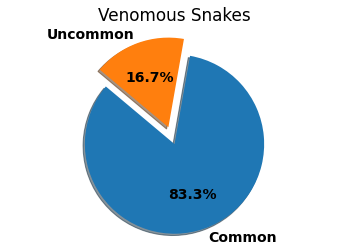

In [26]:
labels = ['Common', 'Uncommon']
counts = [5, 1]  
explode = (0.2, 0)

plt.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Venomous Snakes')
plt.show()

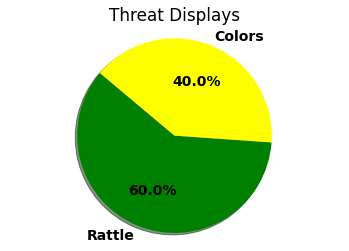

In [27]:
labels = ['Rattle', 'Colors']
counts = [3, 2] 
colors = ['green', 'yellow']
explode = (0.2, 0)


plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, shadow=True, startangle=140)
plt.axis('equal') 
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'
plt.title('Threat Displays')
plt.show()